Bitcoin (BTC) became a trending topic after its [price peaked in 2018](https://intranet.hbtn.io/rltoken/l0VAZKyAwAswj2P_IeN3PA). Many have sought to predict its value in order to accrue wealth. This is an attempt to use my knowledge of RNNs to attempt just that, given the [coinbase](https://drive.google.com/file/d/16MgiuBfQKzXPoWFWi2w-LKJuZ7LgivpE/view) and [bitstamp](https://drive.google.com/file/d/15A-rLSrfZ0td7muSrYHy0WX9ZqrMweES/view) datasets

In [ ]:
import pandas as pd
from typing import Tuple
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

- [x] Data loading (tf dataset)
- [] test RNN in Keras
- [] RNN architecture in Keras
- [] RNN training

## forecast_btc.py in Keras

In [ ]:
"""creates, trains, and validates a keras model for the forecasting of BTC"""

"""
Your model should use the past 24 hours of BTC data to predict the value of BTC at the close of the following hour (approximately how long the average transaction takes):
Your model should use an RNN architecture of your choosing
Your model should use mean-squared error (MSE) as its cost function
You should use a tf.data.Dataset to feed data to your model
Because the dataset is raw, you will need to create a script, preprocess_data.py to preprocess this data. Here are some things to consider:

Are all of the data points useful?
Are all of the data features useful?
Should you rescale the data?
Is the current time window relevant?
How should you save this preprocessed data?
"""

In [ ]:
coinBaseLink = "https://drive.google.com/u/0/uc?id=16MgiuBfQKzXPoWFWi2w-LKJuZ7LgivpE&export=download&confirm=t&uuid=4024be5f-e199-414e-a288-6f7101cbb902"
bitStampLink = "https://drive.google.com/u/0/uc?id=15A-rLSrfZ0td7muSrYHy0WX9ZqrMweES&export=download&confirm=t&uuid=a9086e47-7a2e-4794-bc95-1c7b98fa174b"


### Experiments

In [ ]:
print(bit_df.shape)
bit_df2 = bit_df.tail(round(bit_df.shape[0] * 0.35))
print(bit_df2.shape)

(4363457, 8)
(1745383, 8)


In [ ]:
coin_df2 = coin_df.tail(round(coin_df.shape[0] * 0.35))
bit_df2 = bit_df.tail(round(bit_df.shape[0] * 0.35))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd23ed85b50>,
      dtype=object)

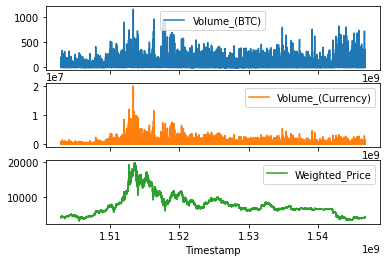

In [ ]:
coin_df2.loc[:, ~coin_df2.columns.isin(['Open', 'High', 'Low', 'Close'])].plot(subplots=True, x="Timestamp")

In [ ]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

4431872/4422102 [==============================] - 0s 0us/step


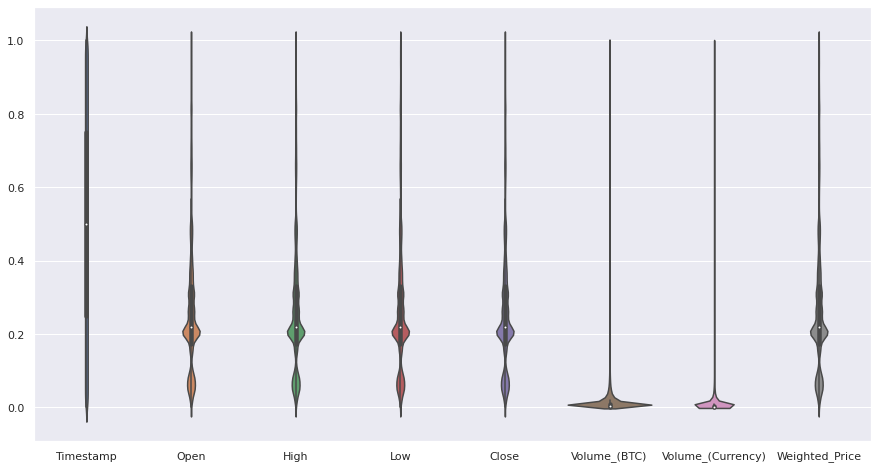

In [ ]:
bit_df3 = bit_df2.copy()
for column in bit_df2:
  bit_df3[column] = (bit_df2[column]-bit_df2[column].min())/(bit_df2[column].max()-bit_df2[column].min())
sns.set(rc = {'figure.figsize':(15,8)})
sns.violinplot(data=bit_df3)


### Raw Data to TF Dataset ready for RNN

In [ ]:
def load_tf_dataset(url: str, printInfo: bool=False) -> tf.data.Dataset:
    zip_path = tf.keras.utils.get_file(
    origin=coinBaseLink,
    fname='coinbase.zip',
    extract=True)
    df = pd.read_csv(zip_path)
    if printInfo:
      print(df.describe())
    return df

In [ ]:
coin_df = load_tf_dataset(coinBaseLink, True)
bit_df = load_tf_dataset(bitStampLink)

# only getting last 35% of data
bit_df2 = bit_df.tail(round(coin_df.shape[0] * 0.35))
coin_df2 = coin_df.tail(round(coin_df.shape[0] * 0.35))

# normalize data
bit_df3 = bit_df2.copy()
coin_df3 = coin_df2.copy()
for column in bit_df2:
  bit_df3[column] = (bit_df2[column]-bit_df2[column].min())/(bit_df2[column].max()-bit_df2[column].min())
for column in coin_df2:
  coin_df3[column] = (coin_df2[column]-coin_df2[column].min())/(coin_df2[column].max()-coin_df2[column].min())

52617216/52602556 [==============================] - 3s 0us/step
          Timestamp          Open          High           Low         Close  \
count  2.099760e+06  1.990691e+06  1.990691e+06  1.990691e+06  1.990691e+06   
mean   1.483899e+09  3.246403e+03  3.247829e+03  3.244856e+03  3.246403e+03   
std    3.638214e+07  3.799154e+03  3.801394e+03  3.796761e+03  3.799150e+03   
min    1.417412e+09  6.000000e-02  6.000000e-02  6.000000e-02  6.000000e-02   
25%    1.452410e+09  4.195800e+02  4.196400e+02  4.195000e+02  4.195700e+02   
50%    1.483906e+09  1.014580e+03  1.014890e+03  1.014150e+03  1.014530e+03   
75%    1.515402e+09  6.322630e+03  6.324010e+03  6.321090e+03  6.322670e+03   
max    1.546899e+09  1.989199e+04  1.989199e+04  1.989198e+04  1.989199e+04   

       Volume_(BTC)  Volume_(Currency)  Weighted_Price  
count  1.990691e+06       1.990691e+06    1.990691e+06  
mean   7.849139e+00       3.600157e+04    3.246341e+03  
std    1.873222e+01       1.401879e+05    3.799078e+

In [ ]:
def PrepData(df: pd.DataFrame, input_width: int, offset: int, label_width: int, batch_size: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
  """
  df : pandas DataFrame to prepare for time series RNN model
  input_width : how much past data will be used to make prediction 
  offset : how much into the future prediction will be
  label width : how many steps predicted
  batch size : how much data is stacked

  Returns : a train, val, and test Tensorflow datasets where each iterable element is (inputs, label)
  """
  n = len(df)
  train_ds = df_to_ds(df[0:int(n*0.7)], input_width, offset, batch_size, label_width)
  val_ds = df_to_ds(df[int(n*0.7):int(n*0.9)], input_width, offset, batch_size, label_width)
  test_ds = df_to_ds(df[int(n*0.9):], input_width, offset, batch_size, label_width)
  return train_ds, val_ds, test_ds

def df_to_ds(df, input_width, offset, batch_size, label_width):
    np_data = np.array(df, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
    data=np_data,
    targets=None,
    sequence_length = input_width + offset,
    sequence_stride = 1,
    shuffle=True,
    batch_size=batch_size,)
    ds = ds.map(lambda x: split_window(x, input_width, offset, label_width))
    return ds

def split_window(features, input_width, offset, label_width):
  """ splits combined data and labels into (data, labels)"""
  inputs = features[:, slice(0, input_width), :]
  labels = features[:, slice(input_width + offset - label_width, input_width + offset), :]
  return inputs, labels

In [ ]:
# df, input shape, offset, label size, batch size
train, val, test = PrepData(bit_df3, 1, 1, 1, 32)

In [ ]:
for i, j in train.take(1):
  print(i.shape, j.shape)
for i, j in val.take(1):
  print(i.shape, j.shape)
for i, j in test.take(1):
  print(i.shape, j.shape)

(32, 1, 8) (32, 1, 8)
(32, 1, 8) (32, 1, 8)
(32, 1, 8) (32, 1, 8)


In [ ]:
i = 0
for poo in train.take(1):
  print(poo)

(<tf.Tensor: shape=(32, 1, 8), dtype=float32, numpy=
array([[[0.34504536, 0.3053394 , 0.3052207 , 0.3037311 , 0.30472282,
         0.02696663, 0.01268138, 0.30423978]],

       [[0.4857106 , 0.3262629 , 0.32653442, 0.32616124, 0.3266304 ,
         0.03659004, 0.0180017 , 0.32641625]],

       [[0.21198098, 0.440891  , 0.44161075, 0.43989673, 0.44047695,
         0.02052228, 0.01239602, 0.4408055 ]],

       [[0.65086436, 0.19455656, 0.19441894, 0.19456084, 0.19456074,
         0.0006841 , 0.00024821, 0.19455764]],

       [[0.43457544, 0.33055565, 0.33044124, 0.3305598 , 0.33055958,
         0.00015729, 0.00007802, 0.33055672]],

       [[0.6211276 , 0.1845228 , 0.18438405, 0.18452772, 0.18452762,
         0.00255682, 0.00090256, 0.18452418]],

       [[0.65402395, 0.19604738, 0.19591   , 0.19605166, 0.19605154,
         0.00018731, 0.00006823, 0.19604844]],

       [[0.31548002, 0.4324716 , 0.43408385, 0.43079406, 0.4307938 ,
         0.01076727, 0.00641417, 0.43231362]],

       [[0.

In [ ]:
dir(val)

### Raw Dataset to Pandas DF (TF Dataset did not work)

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
def data_to_np(df, input_width, offset, label_width):
    """ 
    turns a data frame into np data for time series forecasting
    inputs dataframe 
    returns:
        np.ndarray(samples, input_width, features)
        np.ndarray(samples, label_width, features)
    """    
    np_data = np.array(df, dtype=np.float32)
    windows = np.lib.stride_tricks.sliding_window_view(np_data, (input_width + offset + label_width, np_data.shape[1]))
    windows = windows.reshape(((-1, input_width + offset + label_width, np_data.shape[1])))
    return windows[:, :input_width], windows[:, input_width + offset:input_width + offset + label_width]

def data_to_np_batches(df, input_width, offset, label_width, batch_size=32):
    """ 
    turns a data frame into np data for time series forecasting
    inputs dataframe 
    returns:
        np.ndarray(samples, batch_size, input_width, features)
        np.ndarray(samples, batch_size, label_width, features)
    """    
    np_data = np.array(df, dtype=np.float32)
    windows = np.lib.stride_tricks.sliding_window_view(np_data, (input_width + offset + label_width, np_data.shape[1]))
    windows = windows.reshape(((-1, input_width + offset + label_width, np_data.shape[1])))
    batches = windows[windows.shape[0] % batch_size:].reshape(-1, batch_size, input_width + offset + label_width, np_data.shape[1])
    return batches[:, :, :input_width, :], batches[:, :, input_width + offset:, :]

In [ ]:
dat, lab = data_to_np_batches(bit_df2, 1440, 6, 1)
print(dat.shape)
print(lab.shape)

(22920, 32, 1440, 8)
(22920, 32, 1, 8)


### Build RNN Model

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()

  def call(self, inputs):
      return inputs

In [ ]:
baseline = Baseline()

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

baseline.evaluate(val)
# baseline.evaluate(test, verbose=0)

4594/4594 [==============================] - 54s 12ms/step - loss: nan - mean_absolute_error: nan


[nan, nan]

['OVERLOADABLE_OPERATORS', '_USE_EQUALITY', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__bool__', '__class__', '__complex__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__iter__', '__le__', '__len__', '__long__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmatmul__', '__rmod__', '__rmul__', '__ror__', '__round__', '__rpow__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__tf_tracing_type__', '__truediv__', '__weakref__', '__xor__', '_add_consumer', '_as_node_def_inpu

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, val, test, train, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=val,
                      callbacks=[early_stopping])
  return history

## playground

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

13582336/13568290 [==============================] - 1s 0us/step


In [ ]:
# print(df.columns)
# print(df.describe())
print(df["Date Time"].head(10))

0    01.01.2009 00:10:00
1    01.01.2009 00:20:00
2    01.01.2009 00:30:00
3    01.01.2009 00:40:00
4    01.01.2009 00:50:00
5    01.01.2009 01:00:00
6    01.01.2009 01:10:00
7    01.01.2009 01:20:00
8    01.01.2009 01:30:00
9    01.01.2009 01:40:00
Name: Date Time, dtype: object


In [ ]:
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


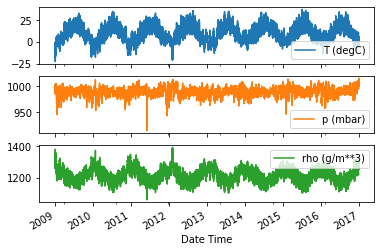

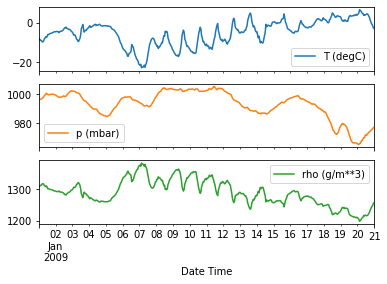

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

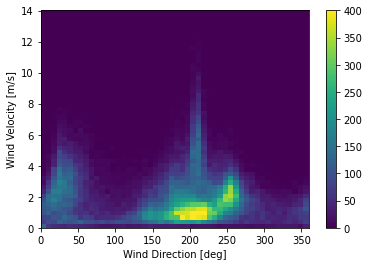

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

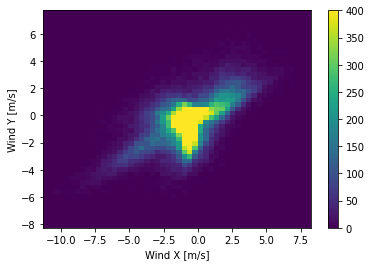

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

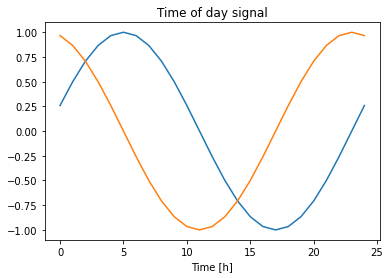

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

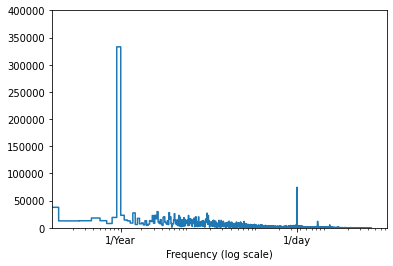

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

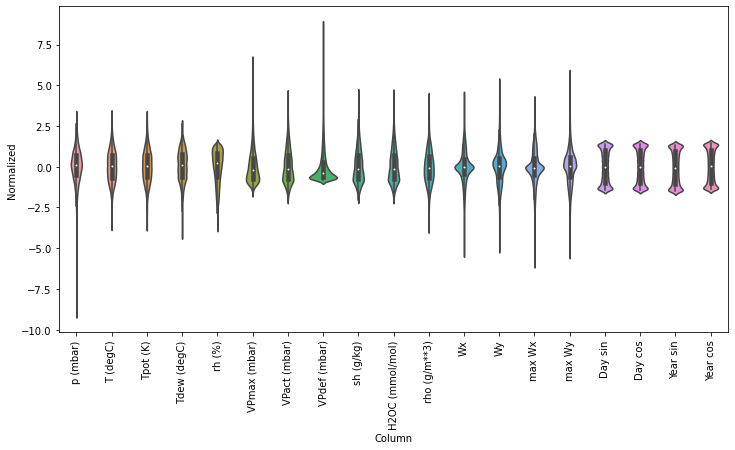

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels
  
  def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')


    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
print(w1)
print()
print(w2)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']


In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [ ]:
w2.example = example_inputs, example_labels
w2.plot()

AttributeError: ignored

(<tf.Tensor: shape=(32, 6, 19), dtype=float32, numpy=
 array([[[ 0.5222869 , -0.07951596, -0.11976942, ...,  0.9091021 ,
           0.3282631 , -1.3254553 ],
         [ 0.50661945, -0.09800249, -0.13696189, ...,  0.59774905,
           0.32728168, -1.3257399 ],
         [ 0.52590245, -0.11186738, -0.15300821, ...,  0.24566741,
           0.32630008, -1.3260238 ],
         [ 0.50420904, -0.02290095, -0.06246116, ..., -0.12314909,
           0.32531828, -1.326307  ],
         [ 0.45118082,  0.1966266 ,  0.1598949 , ..., -0.48356622,
           0.32433623, -1.3265896 ],
         [ 0.39694738,  0.5201409 ,  0.4854058 , ..., -0.8110221 ,
           0.323354  , -1.3268714 ]],
 
        [[ 1.0200292 , -0.56016576, -0.63554376, ...,  0.12335392,
           0.13448294,  1.4132249 ],
         [ 1.0477486 , -0.5255035 , -0.60345113, ...,  0.48377106,
           0.13549481,  1.4130765 ],
         [ 1.0742626 , -0.47582096, -0.55645835, ...,  0.81122696,
           0.1365066 ,  1.4129273 ],
       

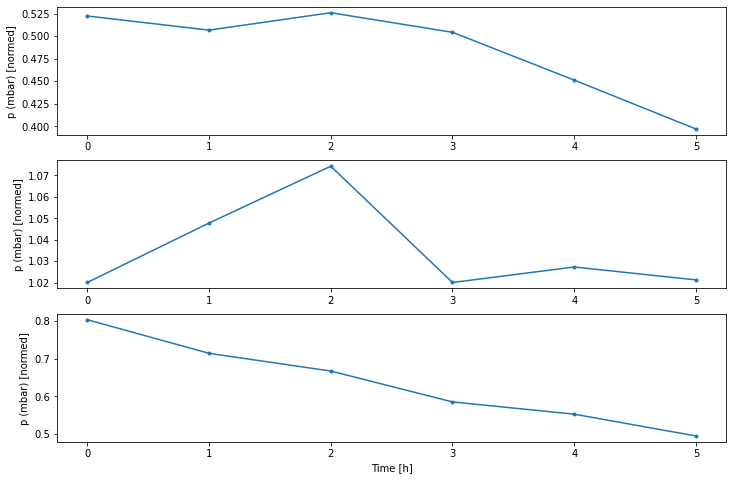

In [ ]:
w2.plot(plot_col='p (mbar)')

In [ ]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 9s 17ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


(<tf.Tensor: shape=(32, 24, 19), dtype=float32, numpy=
 array([[[-0.07789639,  1.2191628 ,  1.2189516 , ..., -1.1218202 ,
           0.32792288, -1.325554  ],
         [-0.152618  ,  1.2792441 ,  1.2854291 , ..., -1.3064041 ,
           0.32694143, -1.3258384 ],
         [-0.15502837,  1.3162172 ,  1.3221064 , ..., -1.4019518 ,
           0.32595974, -1.326122  ],
         ...,
         [ 0.2450938 ,  0.61835057,  0.59543765, ..., -0.18448152,
           0.30726922, -1.33138   ],
         [ 0.24147823,  0.7500671 ,  0.72724664, ..., -0.5410703 ,
           0.3062835 , -1.3316498 ],
         [ 0.2258108 ,  0.90027016,  0.8773943 , ..., -0.86077905,
           0.30529758, -1.3319188 ]],
 
        [[ 0.2535301 ,  0.6368371 ,  0.6137763 , ..., -1.2815549 ,
          -1.2681595 ,  0.7948563 ],
         [ 0.30896872,  0.75353336,  0.7249543 , ..., -1.3925658 ,
          -1.2675973 ,  0.7956981 ],
         [ 0.33307245,  0.8009051 ,  0.76965475, ..., -1.4086688 ,
          -1.2670344 ,  0.796

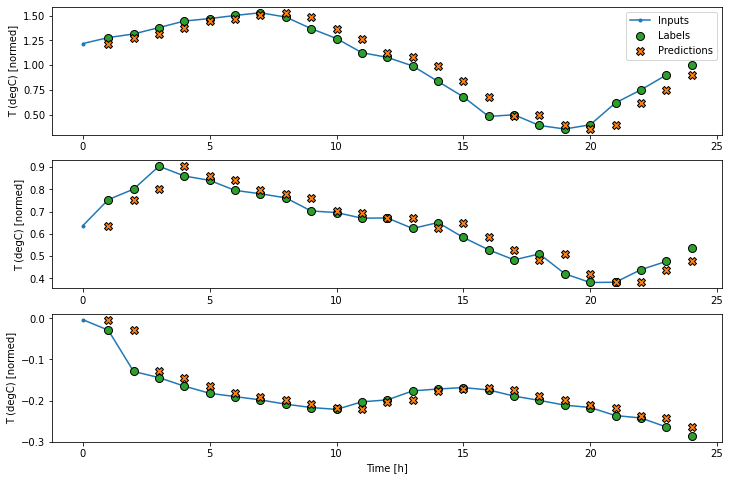

In [ ]:
wide_window.plot(baseline)

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 38s 24ms/step - loss: 0.2285 - mean_absolute_error: 0.2786 - val_loss: 0.0154 - val_mean_absolute_error: 0.0938
Epoch 2/20
1534/1534 [==============================] - 23s 15ms/step - loss: 0.0122 - mean_absolute_error: 0.0820 - val_loss: 0.0097 - val_mean_absolute_error: 0.0733
Epoch 3/20
1534/1534 [==============================] - 29s 19ms/step - loss: 0.0098 - mean_absolute_error: 0.0731 - val_loss: 0.0093 - val_mean_absolute_error: 0.0715
Epoch 4/20
1534/1534 [==============================] - 31s 20ms/step - loss: 0.0096 - mean_absolute_error: 0.0720 - val_loss: 0.0091 - val_mean_absolute_error: 0.0708
Epoch 5/20
1534/1534 [==============================] - 28s 19ms/step - loss: 0.0095 - mean_absolute_error: 0.0715 - val_loss: 0.0090 - val_mean_absolute_error: 0.0700
Epoch 6/20
1534/1534 [==============================] - 28s 18ms/step - loss: 0.0093 - mean_absolute_error: 0.0710 - val_loss: 0.0089 - val_mean_absolute_error:

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


(<tf.Tensor: shape=(32, 24, 19), dtype=float32, numpy=
 array([[[-0.07789639,  1.2191628 ,  1.2189516 , ..., -1.1218202 ,
           0.32792288, -1.325554  ],
         [-0.152618  ,  1.2792441 ,  1.2854291 , ..., -1.3064041 ,
           0.32694143, -1.3258384 ],
         [-0.15502837,  1.3162172 ,  1.3221064 , ..., -1.4019518 ,
           0.32595974, -1.326122  ],
         ...,
         [ 0.2450938 ,  0.61835057,  0.59543765, ..., -0.18448152,
           0.30726922, -1.33138   ],
         [ 0.24147823,  0.7500671 ,  0.72724664, ..., -0.5410703 ,
           0.3062835 , -1.3316498 ],
         [ 0.2258108 ,  0.90027016,  0.8773943 , ..., -0.86077905,
           0.30529758, -1.3319188 ]],
 
        [[ 0.2535301 ,  0.6368371 ,  0.6137763 , ..., -1.2815549 ,
          -1.2681595 ,  0.7948563 ],
         [ 0.30896872,  0.75353336,  0.7249543 , ..., -1.3925658 ,
          -1.2675973 ,  0.7956981 ],
         [ 0.33307245,  0.8009051 ,  0.76965475, ..., -1.4086688 ,
          -1.2670344 ,  0.796

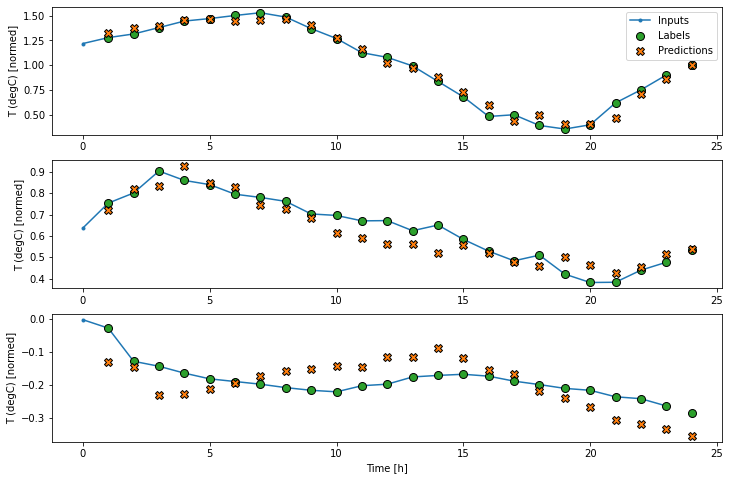

In [ ]:
wide_window.plot(linear)

## From [Time Series Forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network)

### Data Cleaning

In [ ]:
# coinBaseLink = "https://drive.google.com/u/0/uc?id=16MgiuBfQKzXPoWFWi2w-LKJuZ7LgivpE&export=download&confirm=t&uuid=4024be5f-e199-414e-a288-6f7101cbb902"
bitStampLink = "https://drive.google.com/u/0/uc?id=15A-rLSrfZ0td7muSrYHy0WX9ZqrMweES&export=download&confirm=t&uuid=a9086e47-7a2e-4794-bc95-1c7b98fa174b"


def load_tf_dataset(url: str, printInfo: bool=False) -> tf.data.Dataset:
    zip_path = tf.keras.utils.get_file(
    origin=coinBaseLink,
    fname='coinbase.zip',
    extract=True)
    df = pd.read_csv(zip_path)
    if printInfo:
      print(df.describe())
    return df

# coin_df = load_tf_dataset(coinBaseLink, True)
bit_df = load_tf_dataset(bitStampLink)

In [ ]:
# dropping "nan" rows
bit_df = bit_df.fillna(-1)
# coin_df = coin_df.fillna(-1)

bit_df = bit_df.drop(columns=["Open", "High", "Low", "Weighted_Price"])

# only using most recent, relevant data
# bit_df = bit_df.tail(round(bit_df.shape[0] * .35))
# coin_df = coin_df.tail(round(coin_df.shape[0] * .35))

bit_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Timestamp,2099760.0,1.483899e+09,3.638214e+07,1.417412e+09,1.452410e+09,1.483906e+09,1.515402e+09,1.546899e+09
Close,2099760.0,3.077721e+03,3.768705e+03,-1.000000e+00,3.790600e+02,8.936300e+02,6.205620e+03,1.989199e+04
Volume_(BTC),2099760.0,7.389484e+00,1.834464e+01,-1.000000e+00,7.027299e-01,2.415276e+00,7.120792e+00,1.563267e+03
Volume_(Currency),2099760.0,3.413147e+04,1.367321e+05,-1.000000e+00,4.703089e+02,3.067300e+03,1.787428e+04,1.997076e+07


In [ ]:
def split_data(df, train_size, val_size, test_size):
    n = df.shape[0]
    train_df = df[0:int(n*train_size)]
    val_df = df[int(n*train_size):int(n*(train_size + val_size))]
    test_df = df[int(n* (train_size + val_size)):]
    num_features = df.shape[1]
    return train_df, val_df, test_df, num_features

bit_train, bit_val, bit_test, bit_feat = split_data(bit_df, 0.85, 0.15, 0)

In [ ]:
def normalize_df(df):
    mean = df.mean()
    std = df.std()
    return (df - mean) / std

bit_train = normalize_df(bit_train)
bit_val = normalize_df(bit_val)
bit_test = normalize_df(bit_test)

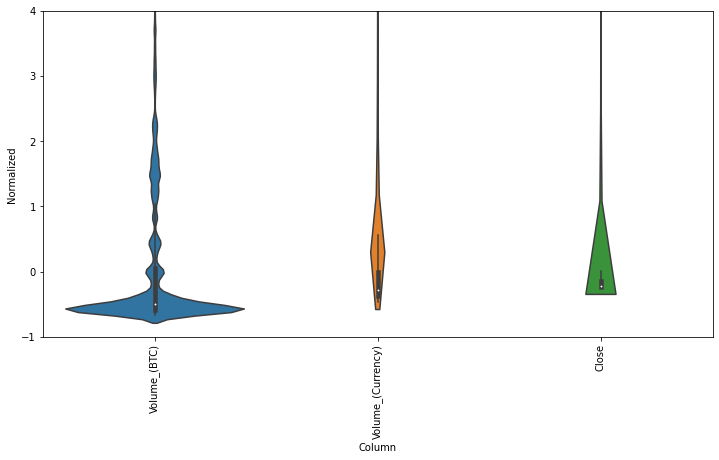

In [ ]:
graph_bit_train = bit_train.copy()
graph_bit_train = graph_bit_train.drop(columns=["Timestamp"])
graph_bit_train = graph_bit_train.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=graph_bit_train)
_ = ax.set_xticklabels(["Volume_(BTC)", "Volume_(Currency)", "Close"], rotation=90)
_ = ax.set_ylim(-1, 4)

### Setup

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

In [ ]:
single_step_window = WindowGenerator(144, 1, 6, bit_train, bit_val, bit_test, ["Weighted_Price"])

In [ ]:
single_step_window

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
Label indices: [149]
Label column name(s): ['Weighted_Price']

In [ ]:
for i, j in single_step_window.train.take(2):
  print(i.shape, j.shape)

(32, 144, 8) (32, 1, 1)
(32, 144, 8) (32, 1, 1)


### Baseline Model

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, -1:, tf.newaxis]

In [ ]:
column_indices = {name: i for i, name in enumerate(bit_df.columns)}
baseline = Baseline(label_index=column_indices['Weighted_Price'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

KeyError: ignored

### Plotting

In [ ]:
def plot(inputs, labels, predictions):
  
  flat_inputs = inputs.flatten()
  flat_labels = labels.flatten()
  flat_predictions = predictions.flatten()
  plt.figure(figsize=(30, 8))
  plt.plot(np.arange(len(flat_inputs)), flat_inputs, label='Inputs', marker='.', zorder=-10)
  plt.scatter(np.arange(inputs.shape[2], flat_inputs.shape[0] + 1, inputs.shape[2]), flat_labels, edgecolors='k', label='Labels', c='#2ca02c', s=64)  
  plt.scatter(np.arange(inputs.shape[2], flat_inputs.shape[0] + 1, inputs.shape[2]), flat_predictions, marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
  plt.ylabel('Price')
  plt.legend()
  plt.xlabel('Time')

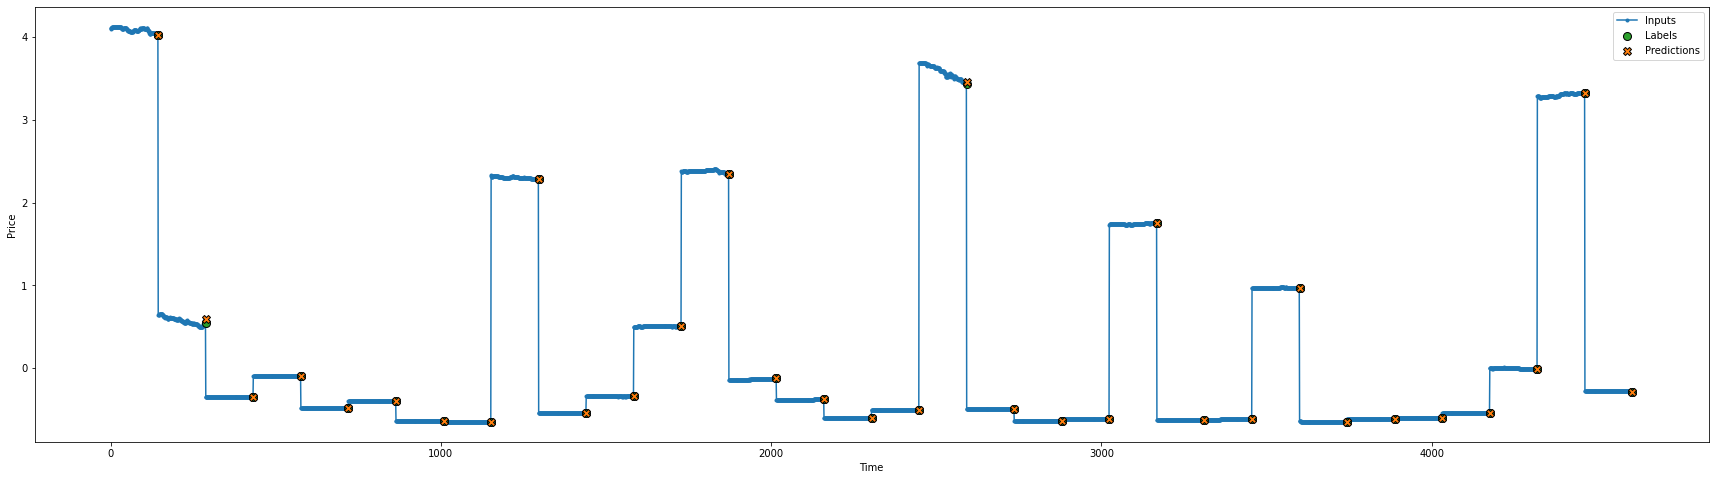

In [ ]:
inputs = []
labels = []
predictions = []
for dat, lab in single_step_window.train.take(1):
  inputs.append(dat[:, :, 7])
  labels.append(lab)
  predictions.append(baseline(dat))
plot(np.array(inputs), np.array(labels), np.array(predictions))

### RNN

#### LSTM

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
wide_window = WindowGenerator(144, 1, 6, bit_train, bit_val, bit_test, label_columns=['Close'])

wide_window

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
Label indices: [149]
Label column name(s): ['Close']

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')
lstm_model.fit(wide_window.train, epochs=20,
                      validation_data=wide_window.val,
                      callbacks=[early_stopping])

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
 3790/43542 [=>............................] - ETA: 42:39 - loss: 0.0025 - mean_absolute_error: 0.0143

KeyboardInterrupt: ignored

#### GRU

In [ ]:
print(bit_train.shape)

(1784796, 4)


In [ ]:
i = 0
for tr in wide_window.train:
  i += 1
print(i)

NameError: ignored

In [ ]:
wide_window = WindowGenerator(144, 1, 6, bit_train, bit_val, bit_test, label_columns=['Close'])

wide_window

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
Label indices: [149]
Label column name(s): ['Close']

In [ ]:
GRU_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, GRU_units]
    tf.keras.layers.GRU(30, return_sequences=True, kernel_regularizer="l1_l2", recurrent_regularizer="l1_l2",),
    K.layers.Dropout(0.3),
    tf.keras.layers.GRU(10, return_sequences=True, kernel_regularizer="l1_l2", recurrent_regularizer="l1_l2"),
    K.layers.Dropout(0.3),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
        ])


GRU_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(), #clipnorm=1),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Machine Learning/supervised learning/0x01 - Time Series/bitCoinModelnoNorm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  mode='min')

In [ ]:
GRU_model.fit(wide_window.train, epochs=64,
                      validation_data=wide_window.val,
                      callbacks=[early_stopping, model_checkpoint_callback])


val_performance['GRU'] = GRU_model.evaluate(wide_window.val)
performance['GRU'] = GRU_model.evaluate(wide_window.test, verbose=0)

Epoch 1/64
55771/55771 [==============================] - 1701s 30ms/step - loss: 0.1212 - mean_absolute_error: 0.1629 - val_loss: 0.0822 - val_mean_absolute_error: 0.0469
Epoch 2/64
55771/55771 [==============================] - 1679s 30ms/step - loss: 0.0965 - mean_absolute_error: 0.1608 - val_loss: 0.0796 - val_mean_absolute_error: 0.0629
Epoch 3/64
55771/55771 [==============================] - 1687s 30ms/step - loss: 0.0943 - mean_absolute_error: 0.1613 - val_loss: 0.0798 - val_mean_absolute_error: 0.0754
Epoch 4/64
55771/55771 [==============================] - 1762s 32ms/step - loss: 0.0933 - mean_absolute_error: 0.1616 - val_loss: 0.0779 - val_mean_absolute_error: 0.0720
Epoch 5/64
55771/55771 [==============================] - 1694s 30ms/step - loss: 0.0926 - mean_absolute_error: 0.1611 - val_loss: 0.0792 - val_mean_absolute_error: 0.0821
Epoch 6/64
55771/55771 [==============================] - 1673s 30ms/step - loss: 0.0921 - mean_absolute_error: 0.1609 - val_loss: 0.0757 - 

NameError: ignored

In [ ]:
GRU_model.evaluate(wide_window.val)

11084/39352 [=======>......................] - ETA: 6:09 - loss: nan - mean_absolute_error: nan

In [ ]:
GRU_model.save("/content/drive/MyDrive/Colab Notebooks/Machine Learning/supervised learning/0x01 - Time Series/bitCoinModelManualSave.h5")

In [ ]:
GRUmodel = K.models.load_model("/content/drive/MyDrive/Colab Notebooks/Machine Learning/supervised learning/0x01 - Time Series/bitCoinModel.h5")

In [ ]:
GRUmodel.evaluate(wide_window.val)

9838/9838 [==============================] - 213s 21ms/step - loss: 0.0762 - mean_absolute_error: 0.0619


[0.07622792571783066, 0.06190381571650505]

In [ ]:
print(GRU_model.get_weights())

In [ ]:
print(dir(wide_window))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'column_indices', 'example', 'input_indices', 'input_slice', 'input_width', 'label_columns', 'label_columns_indices', 'label_indices', 'label_start', 'label_width', 'labels_slice', 'make_dataset', 'shift', 'split_window', 'test', 'test_df', 'total_window_size', 'train', 'train_df', 'val', 'val_df']


In [ ]:
GRUmodel.predict(wide_window.val)

array([[[ 0.06171712],
        [ 0.11654253],
        [ 0.15361923],
        ...,
        [ 0.23086613],
        [ 0.23114017],
        [ 0.23222676]],

       [[ 0.09544986],
        [ 0.17307201],
        [ 0.22556269],
        ...,
        [ 0.32840326],
        [ 0.3276413 ],
        [ 0.32707787]],

       [[-0.55729365],
        [-0.9207905 ],
        [-1.166654  ],
        ...,
        [-1.6609534 ],
        [-1.6611524 ],
        [-1.6624328 ]],

       ...,

       [[ 0.17078295],
        [ 0.29825383],
        [ 0.38451788],
        ...,
        [ 0.5597783 ],
        [ 0.5589175 ],
        [ 0.5583374 ]],

       [[-0.46365827],
        [-0.7653447 ],
        [-0.96922   ],
        ...,
        [-1.3654792 ],
        [-1.3620081 ],
        [-1.3582622 ]],

       [[ 0.1851803 ],
        [ 0.3256019 ],
        [ 0.42051417],
        ...,
        [ 0.6070604 ],
        [ 0.6064356 ],
        [ 0.6059993 ]]], dtype=float32)

In [ ]:
for i in wide_window.val.take(5):
  print(i[0])

tf.Tensor(
[[[-1.0069408   1.033975   -0.28367463 -0.2671561 ]
  [-1.0069299   1.0362746  -0.21615814 -0.17525315]
  [-1.0069189   1.0394745  -0.18836525 -0.137295  ]
  ...
  [-1.00539     1.0007102  -0.32146716 -0.3188718 ]
  [-1.0053791   1.0007102  -0.30715522 -0.29951975]
  [-1.0053681   1.0007176  -0.28721812 -0.27255267]]

 [[-0.25834662  0.95879805 -0.18279193 -0.13308907]
  [-0.25833562  0.9587906  -0.3526099  -0.3610182 ]
  [-0.25832462  0.9587906   0.9244502   1.3530478 ]
  ...
  [-0.25679585  0.97340626 -0.3152808  -0.3107741 ]
  [-0.25678486  0.97340626 -0.35194677 -0.36012015]
  [-0.25677386  0.9734137  -0.34457248 -0.3501956 ]]

 [[-0.16631211  0.22360842 -0.07252005 -0.03619865]
  [-0.16630112  0.22527538 -0.1798428  -0.16092299]
  [-0.16629012  0.22605677  0.08329779  0.14443703]
  ...
  [-0.16476135  0.24364917 -0.21343565 -0.19920881]
  [-0.16475035  0.24364917 -0.2772105  -0.2734823 ]
  [-0.16473934  0.24364917 -0.29394865 -0.2929759 ]]

 ...

 [[-1.2603217   0.47617